<a href="https://colab.research.google.com/github/dhruvi18/Real-Estate-Price-Prediction/blob/main/Real_Estate_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Science Regression project: predicting home prices**





Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,10)

In [ ]:
#loading the data into pandas df
df1=pd.read_csv('/content/Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
df1.shape

(13320, 9)

Examining area type feature

In [ ]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Dropping certain columns which I think are not important for predicting the price

In [ ]:
df2=df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


**Data Cleaning** 

In [ ]:
#handling NAN values by giving no.of rows in a particular column is NA
df2.isnull().sum()


location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [ ]:
#dropping the Nan values because na values are really less compared to dataswt
df3=df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [ ]:
df3.shape

(13246, 5)

In [ ]:
# to check what is unique in size column
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

NOTE:4 bedroom and 4BHK is same

In [ ]:
#Add new feature for bhk
df3['bhk']=df3['size'].apply(lambda x: int(x.split(' ')[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [ ]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [ ]:
 df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


Exploring total sqft

In [ ]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [ ]:
def is_float(x):
  try:
    float(x)
  except:
     return False
  return True  

In [ ]:
df3[~df3['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


NOTE: Above shows that there are some total_sqft which are is range for e.g.2100-2850 so we'll take average in this case.And in some there is 345.0sqmt so we'll drop such values

In [ ]:
#tackling range values
def convert_sqft_to_num(x):
  tokens=x.split('-')
  if len(tokens)==2:
    return (float(tokens[0])+float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None    

In [ ]:
df4=df3.copy()
df4['total_sqft']=df4['total_sqft'].apply(convert_sqft_to_num)

In [ ]:
df4.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


In [ ]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

Feature Engineering

In [ ]:
df5=df4.copy()

In [ ]:
df5['price_per_sqft']=df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [ ]:
len(df5.location.unique())

1304

In [ ]:
 #how many data points available in location
 df5.location=df5.location.apply(lambda x:x.strip())#strip to remove white spaces
 location_stats=df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
 location_stats

location
other               2881
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
                    ... 
LB Shastri Nagar      11
Marsur                11
Narayanapura          11
Nehru Nagar           11
HAL 2nd Stage         11
Name: location, Length: 242, dtype: int64

In [ ]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [ ]:
#Any location having less than 10 data points should be tagged as "other" location. 
#This way number of categories can be reduced by huge amount in order to have fewer dummy columns
df5.location=df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [ ]:
len(df5.location.unique())

242

In [ ]:
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Outlier Removal

In [ ]:
df5.shape

(13246, 7)

In [ ]:
#If you've 400 sqft apartment and 2 bhk it seems suspicious . So we'll remove this outlier by keeping a threshold of 300
df6=df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12502, 7)

In [ ]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

NOTE:Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices.I've to remove outliers per location using mean and one standard deviation

In [ ]:
#function to remove extreme cases by writing function based on std
def remove_pps_outliers(df):
  df_out=pd.DataFrame()
  for key,subdf in df.groupby('location'):
    m=np.mean(subdf.price_per_sqft)
    st=np.std(subdf.price_per_sqft)
    reduced_df=subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
    df_out=pd.concat([df_out,reduced_df],ignore_index=True)
  return df_out


df7=remove_pps_outliers(df6)
df7.shape    

(10241, 7)

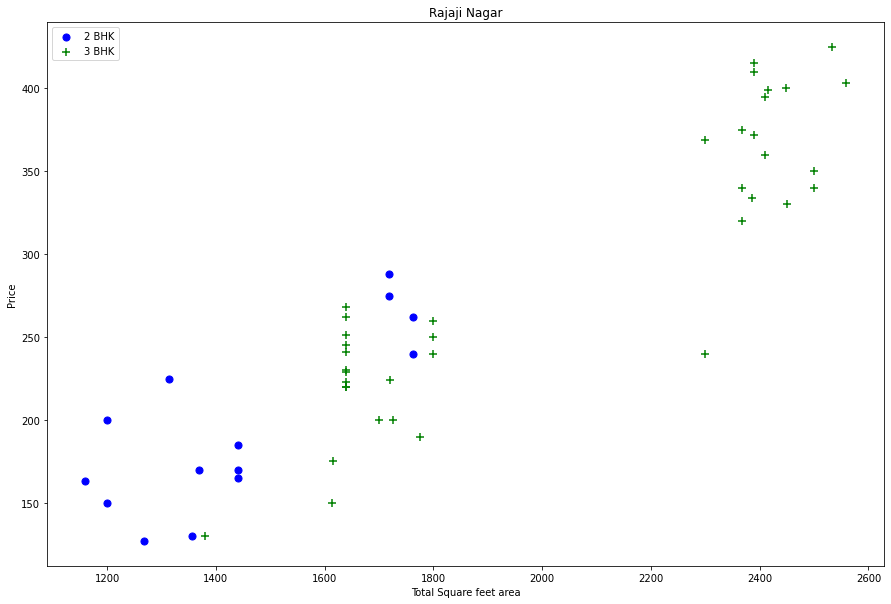

In [ ]:
def plot_scatter_chart(df,location):
  bhk2=df[(df.location==location) & (df.bhk==2)]
  bhk3=df[(df.location==location) & (df.bhk==3)]
  matplotlib.rcParams['figure.figsize']=(15,10)
  plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK',s=50)
  plt.scatter(bhk3.total_sqft,bhk3.price,marker='+',color='green',label='3 BHK',s=50)
  plt.xlabel('Total Square feet area')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()

plot_scatter_chart(df7,'Rajaji Nagar')  

# remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment

In [ ]:
#to remove outliers
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7329, 7)

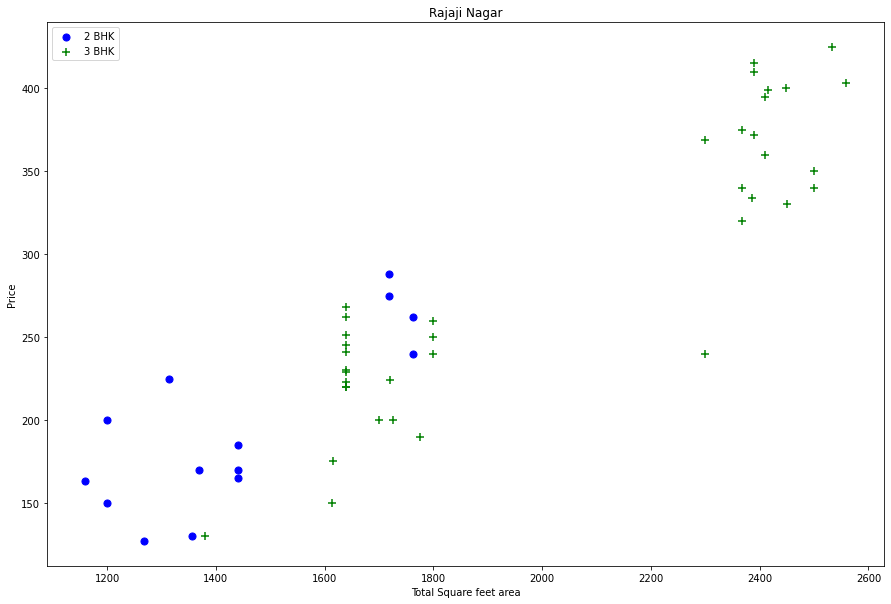

In [ ]:
plot_scatter_chart(df7,'Rajaji Nagar')  

Text(0, 0.5, 'Count')

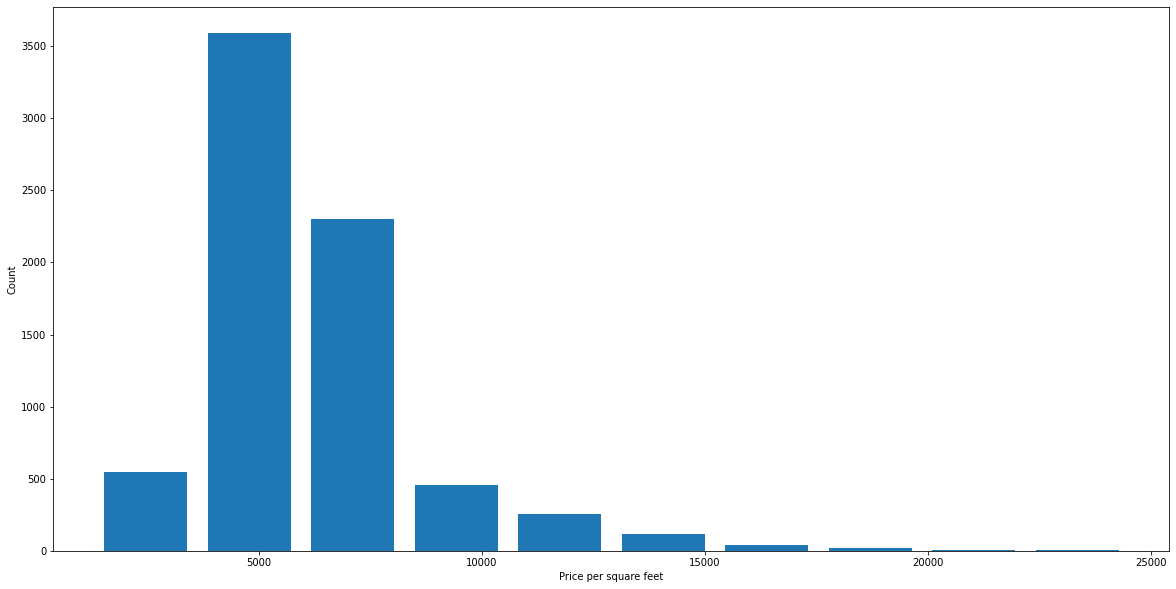

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel('Price per square feet')
plt.ylabel('Count')

In [ ]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [ ]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


NOTE:It is unusual to have 2 more bathrooms than number of bedrooms in a home

Text(0, 0.5, 'Count')

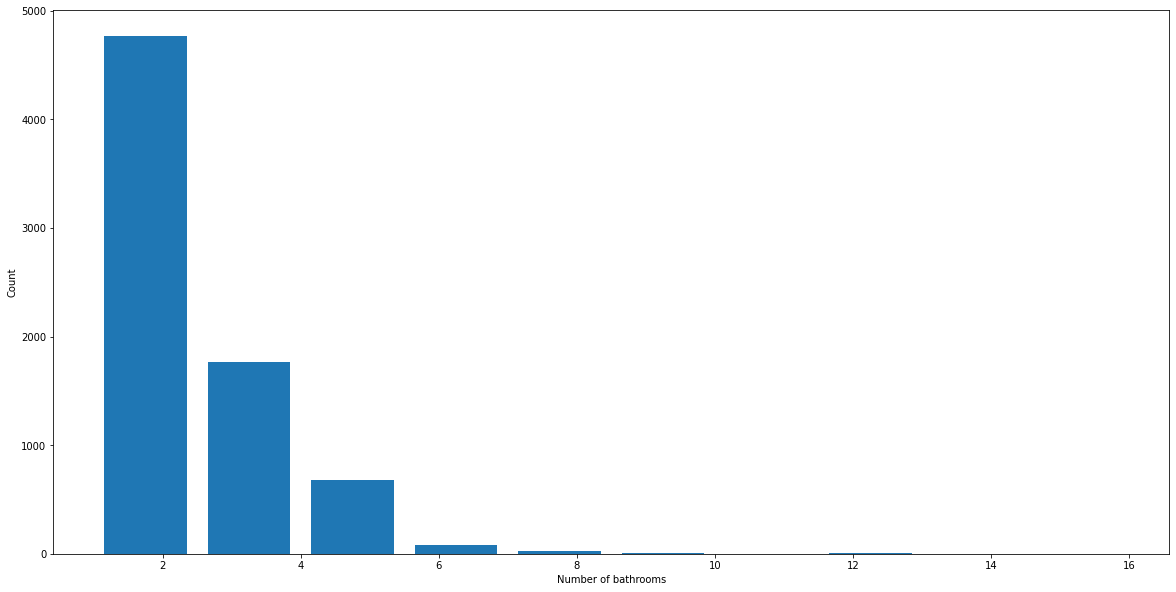

In [ ]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [ ]:
 df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [ ]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7251, 7)

In [ ]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


One Hot Encoding for location

In [ ]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Building a model now

In [ ]:
df12.shape

(7251, 245)

In [ ]:
X=df12.drop(['price'],axis='columns')
X.head

<bound method NDFrame.head of        total_sqft  bath  bhk  1st Block Jayanagar  1st Phase JP Nagar  \
0          2850.0   4.0    4                    1                   0   
1          1630.0   3.0    3                    1                   0   
2          1875.0   2.0    3                    1                   0   
3          1200.0   2.0    3                    1                   0   
4          1235.0   2.0    2                    1                   0   
...           ...   ...  ...                  ...                 ...   
10232      1200.0   2.0    2                    0                   0   
10233      1800.0   1.0    1                    0                   0   
10236      1353.0   2.0    2                    0                   0   
10237       812.0   1.0    1                    0                   0   
10240      3600.0   5.0    4                    0                   0   

       2nd Phase Judicial Layout  2nd Stage Nagarbhavi  5th Block Hbr Layout  \
0            

In [ ]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8452277697874383

Using K Fold cross validation to check accuracy of linear regression model

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

Linear regression is good model for this dataset because the average of the accuracy is 80 of 5 fold

Using grid-search CV to check different model

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
 from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
 model_params = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }

In [ ]:
scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for model_name,mp in model_params.items():
  classifier=GridSearchCV(mp['model'],mp['params'],cv=cv,return_train_score=False)
  #fitting data into classifier
  classifier.fit(X,y)

  scores.append({
      'model':model_name,
      'best_score':classifier.best_score_,
      'best hyperparameters':classifier.best_params_
  })
  df = pd.DataFrame(scores,columns=['model','best_score','best hyperparameters'])
df

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pi

,model,best_score,best hyperparameters
0,linear_regression,0.818354,{'normalize': True}
1,lasso,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.719282,"{'criterion': 'mse', 'splitter': 'best'}"


Based on above results we got to know Linear Regression is the best model

Predicting the model

In [ ]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr.predict([x])[0]

In [ ]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


86.80519395234735

In [ ]:
predict_price('Indira Nagar',1000, 3, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


184.58430202033142